### Import standard modules


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

### Initialize standard logger

In [2]:
import logging

logging.basicConfig(format="%(asctime)s.%(msecs)03d %(levelname)-8s %(message)s",
                    datefmt="%Y-%m-%d %H:%M:%S",
                    level=logging.INFO)

### Create the Simulation State

There are 2 objects that hold the state of the simulation:
  1. *Population* is a container for the state each persion
  2. *Society* is the state of the government, eg the testing processes

In [3]:
from codit.society import Society
from codit.population.covid import PersonCovid
from codit.population.networks.city import CityPopulation
from codit.population.networks.city_config.city_cfg import city_paras
from codit.society.alternatives import UKSociety

/home/paul/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# For now set a small population for Leeds (down by a factor of 20):

#### TODO: delete this box

In [4]:
POPULATION_SIZE = city_paras["Leeds"]['population']

In [5]:
# Most classrooms and workplaces are closed
LOCKDOWN_CFG = dict(classrooms=0.66, workplaces=0.66, ephemeral_contact=0.0)

# We assume that Covid survivors, and the vaccinated, have an 80% chance of catching and passing on the disease another time:
X_IMMUNITY=0.8
# However this factor is square for the indian variant (and 80% squared is 64%)

pop = CityPopulation(POPULATION_SIZE, Society(config=dict(X_IMMUNITY=X_IMMUNITY)), 
                     person_type=PersonCovid, lockdown_config=LOCKDOWN_CFG)

SOCIETY_CFG = dict(DAILY_TEST_CAPACITY_PER_HEAD=0.01, 
                            PROB_APPLY_FOR_TEST_IF_SYMPTOMS=0.33)

soc = UKSociety(config=SOCIETY_CFG)

2021-05-23 21:20:34.893 INFO     Building a set of 317255 households from which to build a population
2021-05-23 21:21:51.495 INFO     306325 households of mean size 2.59
2021-05-23 21:21:55.491 INFO     140009 buildings of mean size 5.66
2021-05-23 21:22:23.011 INFO     2015 classrooms of mean size 29.28
2021-05-23 21:22:23.278 INFO     117 care_homes of mean size 105.22
2021-05-23 21:22:24.214 INFO     93730 workplaces of mean size 5.64
2021-05-23 21:22:27.429 INFO     66.0% of workplaces closed by lockdown, leaving 33484 open, of average Income Decile 4.88 (and st dev 3.13).
2021-05-23 21:22:27.638 INFO     66.0% of classrooms closed by lockdown, leaving 728 open, of average Income Decile 4.30 (and st dev 3.04).
2021-05-23 21:22:27.670 INFO     Adding 340654 permanent contact groups
2021-05-23 21:22:27.670 INFO     Adding 0 ephemeral contact pairs
2021-05-23 21:22:28.603 INFO     Adding 239373 contacts each within one of the 140009 buildings (contact density of 0.75)


### Create the 2 variants

In [6]:
from codit.disease import Covid
from codit.immunity import ImmuneResponse

kent_variant = Covid(variant=ImmuneResponse.B_1_1_7_INFECTION)
indian_variant = Covid(variant=ImmuneResponse.B_1_617_2_INFECTION)

### Burn in the simulation

In [7]:
from codit.outbreak import Outbreak


BURNIN_DAYS = 30
WINTER_PREVALENCE = 1/40
SEED_SIZE = int(POPULATION_SIZE * WINTER_PREVALENCE)

o_burnin = Outbreak(soc, kent_variant, n_days=BURNIN_DAYS, seed_size=SEED_SIZE, population=pop)
o_burnin.simulate()


2021-05-23 21:22:55.705 INFO     Day 1, prop infected is 0.03, prop infectious is 0.0178
2021-05-23 21:26:51.402 INFO     Day 30, prop infected is 0.11, prop infectious is 0.0135


### Run the simulation for January and February

2021-05-23 21:27:25.205 INFO     Day 1, prop infected is 0.11, prop infectious is 0.0131
2021-05-23 21:34:09.275 INFO     Day 51, prop infected is 0.14, prop infectious is 0.0028
2021-05-23 21:35:14.630 INFO     Day 60, prop infected is 0.14, prop infectious is 0.0022
2021-05-23 21:35:17.073 INFO      Realized R0 of early infections is nan
2021-05-23 21:35:17.074 INFO      14.4 percent of the population was infected during the epidemic


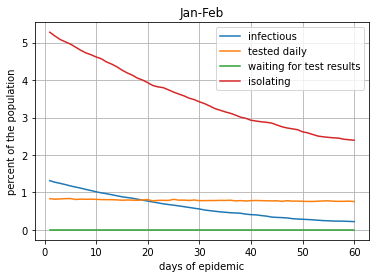

In [8]:
from codit.outbreak_recorder import WardComponent

DAYS_MONTH = 30

o_Jan_Feb = Outbreak(soc, n_days=DAYS_MONTH * 2, population=pop, reset_population=False)
o_Jan_Feb.recorder.add_component(WardComponent(o_Jan_Feb))
o_Jan_Feb.simulate()
o_Jan_Feb.recorder.plot(title="Jan-Feb")

### March 
  1. Open classrooms
  2. People now 'brush past' on average 0.3 others randomly per day (see COMIX)
  3. Vaccinate the over 60s

In [9]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.66, ephemeral_contact=0.3)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)
pop.clear_memory()

for i, p in enumerate(pop.people):
    if p.age > 60 and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-23 21:35:20.539 INFO     66.0% of workplaces closed by lockdown, leaving 33537 open, of average Income Decile 4.88 (and st dev 3.13).
2021-05-23 21:35:20.835 INFO     0.0% of classrooms closed by lockdown, leaving 1660 open, of average Income Decile 4.77 (and st dev 3.10).
2021-05-23 21:35:20.868 INFO     Adding 341639 permanent contact groups
2021-05-23 21:35:21.251 INFO     Adding 118971 ephemeral contact pairs
2021-05-23 21:35:25.019 INFO     Adding 239567 contacts each within one of the 140009 buildings (contact density of 0.75)


2021-05-23 21:36:06.964 INFO     Day 1, prop infected is 0.14, prop infectious is 0.0021
2021-05-23 21:39:40.468 INFO     Day 30, prop infected is 0.15, prop infectious is 0.0012
2021-05-23 21:39:42.927 INFO      Realized R0 of early infections is nan
2021-05-23 21:39:42.928 INFO      14.9 percent of the population was infected during the epidemic


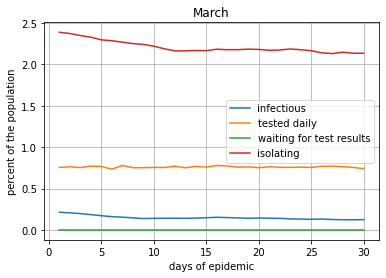

In [10]:
o_March = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_March.recorder.add_component(WardComponent(o_March))
o_March.simulate()
o_March.recorder.plot(title="March")

### April
    1. More workplaces (such as non-essential retail) open up
    2. More people brush past each other as restrictions are lifted
    3. 10 people introduce the Indian variant into the Leeds population
    4. Vaccinate the over 50s

In [11]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.5, ephemeral_contact=0.4)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)

pop.seed_infections(10, indian_variant)
pop.clear_memory()

for i, p in enumerate(pop.people):
    if (60 >= p.age > 50) and i % 20: # vaccinate 19 in every 20 people
        p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-23 21:39:46.597 INFO     50.0% of workplaces closed by lockdown, leaving 49293 open, of average Income Decile 4.88 (and st dev 3.13).
2021-05-23 21:39:46.883 INFO     0.0% of classrooms closed by lockdown, leaving 1639 open, of average Income Decile 4.72 (and st dev 3.08).
2021-05-23 21:39:46.916 INFO     Adding 357374 permanent contact groups
2021-05-23 21:39:47.362 INFO     Adding 158628 ephemeral contact pairs
2021-05-23 21:39:48.254 INFO     Adding 239254 contacts each within one of the 140009 buildings (contact density of 0.75)


2021-05-23 21:40:35.353 INFO     Day 1, prop infected is 0.15, prop infectious is 0.0013
2021-05-23 21:44:12.623 INFO     Day 30, prop infected is 0.15, prop infectious is 0.0011
2021-05-23 21:44:15.078 INFO      Realized R0 of early infections is nan
2021-05-23 21:44:15.079 INFO      15.4 percent of the population was infected during the epidemic


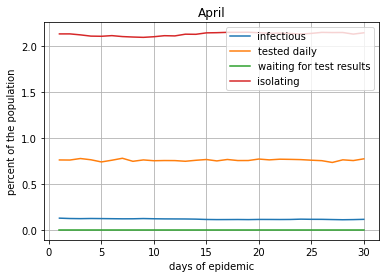

In [12]:
o_April = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_April.recorder.add_component(WardComponent(o_April))
o_April.simulate()
o_April.recorder.plot(title="April")

### May
    1. Even more workplaces open up
    2. More people brush past on average 0.5 others randomly per day


In [13]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.33, ephemeral_contact=0.5)
pop.clear_memory()
pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)

for i, p in enumerate(pop.people):
    if (50 >= p.age > 45) and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-23 21:44:19.139 INFO     33.0% of workplaces closed by lockdown, leaving 62734 open, of average Income Decile 4.92 (and st dev 3.13).
2021-05-23 21:44:19.438 INFO     0.0% of classrooms closed by lockdown, leaving 1647 open, of average Income Decile 4.73 (and st dev 3.08).
2021-05-23 21:44:19.476 INFO     Adding 370823 permanent contact groups
2021-05-23 21:44:23.894 INFO     Adding 198284 ephemeral contact pairs
2021-05-23 21:44:24.793 INFO     Adding 239268 contacts each within one of the 140009 buildings (contact density of 0.75)


### Surge Vaccinations all people over 16?

In [14]:
# for p in pop.people:
#     if p.age > 16:
#         p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-23 21:45:03.609 INFO     Day 1, prop infected is 0.15, prop infectious is 0.0011
2021-05-23 21:48:50.075 INFO     Day 30, prop infected is 0.16, prop infectious is 0.0016
2021-05-23 21:48:52.529 INFO      Realized R0 of early infections is nan
2021-05-23 21:48:52.530 INFO      16.0 percent of the population was infected during the epidemic


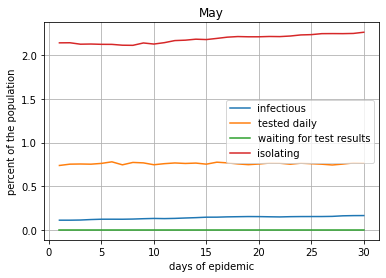

In [15]:
o_May = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_May.recorder.add_component(WardComponent(o_May))
o_May.simulate()
o_May.recorder.plot(title="May")